In [2]:
library(dplyr)
library(rio) #great for exporting, importing
library (stringr)
library(cowplot)
library(ggplot2)
library(tidyr)
library(ggpubr)

library(patchwork)
library(RColorBrewer)
library(viridis)

In [60]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/Eva/opt/anaconda3/envs/R4b/lib/libopenblasp-r0.3.26.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] viridis_0.6.4      viridisLite_0.4.2  RColorBrewer_1.1-3 patchwork_1.1.2   
 [5] ggpubr_0.6.0       tidyr_1.3.1        ggplot2_3.5.0      cowplot_1.1.1     
 [9] stringr_1.5.1      rio_1.0.1          dplyr_1.1.4       

loaded via a namespace (and not attached):
 [1] utf8_1.2.4        generics_0.1.3    rstatix_0.7.2     stringi_1.8.3    
 [5] digest_0.6.35     magrittr_2.0.3    evaluate_0.23     grid_4.3.1       
 [9] pbdZMQ_0.3-11     fastmap_1.1.1     R.oo_1.26.0       jsonlite_1.8.8   
[

## Note about correlation analyses
Correlations were calculated using rlog normalized data (DEseq). 

The 'Tissue' and 'Stress' datasets were normalized separately using DEseq. The diurnal time course samples were removed from this expression atlas dataset to avoid redundancy. 

The short photoperiod leaf, long photoperiod leaf and short photoperiod tuber datasets were normalized all together to calculate rlogs using DEseq. 

The rlogs were z-score normalized before calculating the Pearson's correlations. 

Correlations were calculated across all annotated allelic pairs, no minimum cut off was used. Therefore an initial selection or expressed genes needs to be done. 

### Import correlation data

In [3]:
# ATL SD Leaf
#:::::::::::::::::::::::::::::::::::
SD<- import(file = '~/Dropbox/Potato/RNA-seq_2/RNAseq_analysis/Data/DEseq/combined_files_for_PCA/within_species/atl_diel_correlations/shd_pairwise_corrs.csv',
                                sep =',', header = TRUE, fill = TRUE )

# ATL LD Leaf
#:::::::::::::::::::::::::::::::::::
LD<- import(file = '~/Dropbox/Potato/RNA-seq_2/RNAseq_analysis/Data/DEseq/combined_files_for_PCA/within_species/atl_diel_correlations/lgd_pairwise_corrs.csv',
                                sep =',', header = TRUE, fill = TRUE )

# ATL Tissues (does not contain 'diurnal time course' data)
#::::::::::::::::::::::::::::::::::::::::::::::::::::
Tissue<- import(file = '~/Dropbox/Potato/RNA-seq_2/RNAseq_analysis/Data/DEseq/Julia_Data/newSynt_correlations/tissue_rlog_tissue_pairwise_corrs.csv',
                                sep =',', header = TRUE, fill = TRUE )


# ATL Stress (includes control samples)
#::::::::::::::::::::::::::::::::::::::::::
Stress<- import(file = '~/Dropbox/Potato/RNA-seq_2/RNAseq_analysis/Data/DEseq/Julia_Data/newSynt_correlations/tissue_rlog_stress_pairwise_corrs.csv',
                                sep =',', header = TRUE, fill = TRUE )


In [4]:
SD[1:2,]

,Syntelog,Haplotype_1,Haplotype_2,Correlation
,<chr>,<chr>,<chr>,<dbl>
1,Synt_1,Soltu.Atl_v3.01_4G000020,Soltu.Atl_v3.01_1G000020,0.6893458
2,Synt_1,Soltu.Atl_v3.01_4G000020,Soltu.Atl_v3.01_2G000020,-0.0608554


In [ ]:
SD$Correlation

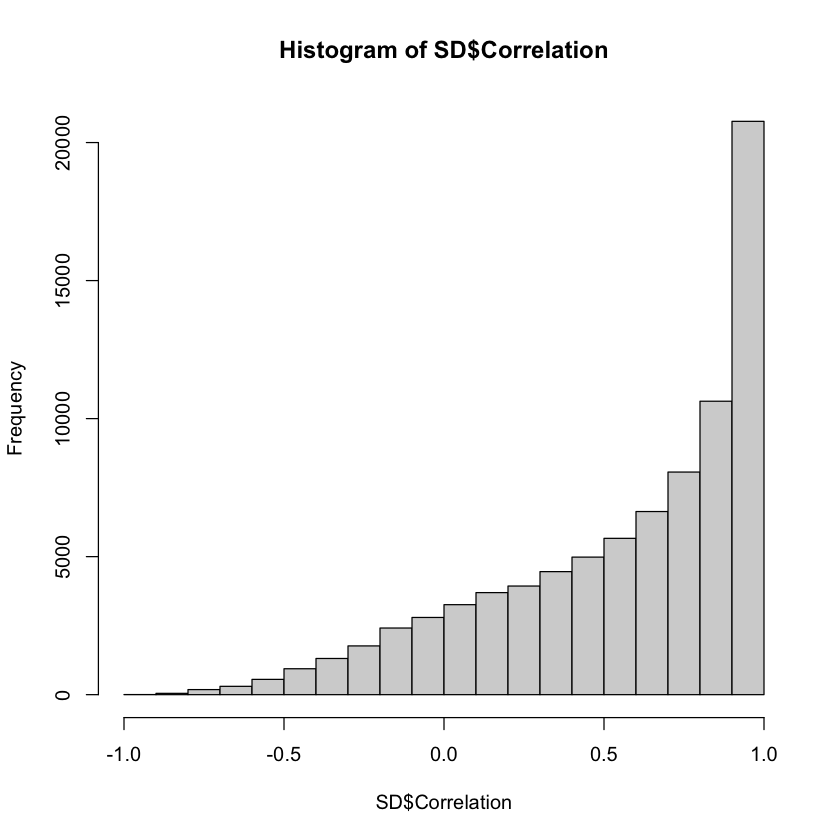

In [5]:
hist(SD$Correlation)

In [38]:
median(abs(Stress$Correlation))
median(abs(Tissue$Correlation))
median(abs(SD$Correlation))
median(abs(LD$Correlation))

[1] 0.8258166

[1] 0.8638547

[1] 0.7367919

[1] 0.7743492

In [39]:
median((Stress$Correlation))
median((Tissue$Correlation))
median((SD$Correlation))
median((LD$Correlation))

[1] 0.8252383

[1] 0.8638129

[1] 0.7356224

[1] 0.7738355

In [40]:
nrow(Stress)
nrow(Tissue)
nrow(SD)
nrow(LD)


[1] 72840

[1] 77119

[1] 68538

[1] 68737

## Get correlations of expressed genes only, eg genes with average expression rlog > 0 in at least one condition in each set of samples

### ...for Tissue and Stress datasets

In [41]:
#IMPORT expressed genes datasets:
#:::::::::::::::::::::::::::::::::

# Tissue
#:::::::::::::::::::::::::::::::::::
TissueExpressed<- import(file = './Results/Tissue_long_av_expressed.csv',
                                sep =',', header = TRUE, fill = TRUE )

# Stress
#:::::::::::::::::::::::::::::::::::
StressExpressed<- import(file = './Results/Stress_long_av_expressed.csv',
                                sep =',', header = TRUE, fill = TRUE )

In [42]:
StressExpressed[1:2,]

,GeneID,Condition,mean_expression,std,MaxExpression
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Soltu.Atl_v3.01_0G000010.1,BTH,0.54395137,0.8611260,0.5439514
2,Soltu.Atl_v3.01_0G000010.1,BTHControl,0.03311851,0.5498508,0.5439514


In [24]:
#TISSUE dataset: Remove transcript information from the Expressed genes dataframe in order to match them with the correlation dataframes 
## REMOVE transcript version for versions from .1-.99 

TissueExpressed <- TissueExpressed %>% rename(target_id = GeneID)

TissueExpressed$target_id<-lapply(TissueExpressed$target_id,
                             function (i){if (str_sub(i,-2,-2) == ".")
                                             { i<- str_sub(i, end = -3)} # i.e. the last character will be -3 position
                                          else if ((str_sub(i,-3,-3) == "."))
                                               { i<- str_sub(i, end = -4)} # i.e. the last character will be -4 position
                                        else {i<-i}
                                          
                                        })


TissueExpressed$target_id <- as.character(TissueExpressed$target_id)
TissueExpressed[1:2,]

,target_id,Condition,mean_expression,std,MaxExpression
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Soltu.Atl_v3.01_0G000010,ClosedFlower,1.52559678,0.07353294,1.877467
2,Soltu.Atl_v3.01_0G000010,ColdLeafControl,0.07708519,0.47580094,1.877467


In [25]:
#STRESS dataset: Remove transcript information from the Expressed genes dataframe in order to match them with the correlation dataframes 
## REMOVE transcript version for versions from .1-.99 
StressExpressed <- StressExpressed %>% rename(target_id = GeneID)

StressExpressed$target_id<-lapply(StressExpressed$target_id,
                             function (i){if (str_sub(i,-2,-2) == ".")
                                             { i<- str_sub(i, end = -3)} # i.e. the last character will be -3 position
                                          else if ((str_sub(i,-3,-3) == "."))
                                               { i<- str_sub(i, end = -4)} # i.e. the last character will be -4 position
                                        else {i<-i}
                                          
                                        })

StressExpressed$target_id <- as.character(StressExpressed$target_id)
StressExpressed[1:2,]

,target_id,Condition,mean_expression,std,MaxExpression
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Soltu.Atl_v3.01_0G000010,BTH,0.54395137,0.8611260,0.5439514
2,Soltu.Atl_v3.01_0G000010,BTHControl,0.03311851,0.5498508,0.5439514


### Filter for expressed genes in Tissue and Stress datasets

In [26]:
TissueExpressed %>% select(target_id) %>% unique() %>% nrow()
StressExpressed %>% select(target_id) %>% unique() %>% nrow()

[1] 104139

[1] 98022

In [27]:
nrow(Tissue)
Tissue <- Tissue %>% filter(Haplotype_1 %in% TissueExpressed$target_id) %>% filter(Haplotype_2 %in% TissueExpressed$target_id)
nrow(Tissue)

[1] 86248

[1] 77119

In [28]:
nrow(Stress)
Stress <- Stress %>% filter(Haplotype_1 %in% StressExpressed$target_id) %>% filter(Haplotype_2 %in% StressExpressed$target_id)
nrow(Stress)

[1] 86248

[1] 72840

## Get expressed genes and rhythmicity information from the diel experiment 

In [29]:
ExprGenes<- import(file = '../ATL_AllelicGroupRhythmicity/Results/ExpressedGenes_JTK_AllelicGroups.csv',
                                sep =',', header = TRUE, fill = TRUE )

In [30]:
ExprGenes[1:2,]

,Syntelog,Tissue,Condition,ATL_expressed_alleles,geneID,target_id,Average,SD,ATL_alleles,BH.Q,ADJ.P,Period,Adj_phase,Amplitude
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,Synt_1,Leaf,LD,4,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_1G000020,7.395377,0.1577245,4,1,1,20,19,0.10051609
2,Synt_1,Leaf,LD,4,Soltu.Atl_v3.01_2G000020.1,Soltu.Atl_v3.01_2G000020,5.948141,0.1212230,4,1,1,20,4,0.09175902


In [31]:
# Select only leaf data, since relatively few genes cycle in the tuber
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
SDLDcyc<- ExprGenes %>% select(target_id,ADJ.P,Condition, Tissue) %>% filter (Tissue == 'Leaf') %>% select(-Tissue) %>% unique()

In [43]:
SDLDcyc[1:2,]

,target_id,ADJ.P,Condition
,<chr>,<dbl>,<chr>
1,Soltu.Atl_v3.01_1G000020,1,LD
2,Soltu.Atl_v3.01_2G000020,1,LD


In [33]:
## Filter only expressed genes in SD-correlation data

nrow(SD)
SD <- SD %>% filter(Haplotype_1 %in% (SDLDcyc%>% filter(Condition == 'SD') %>% pull(target_id))) %>% 
                    filter(Haplotype_2 %in% (SDLDcyc%>% filter(Condition == 'SD') %>% pull(target_id)))
nrow(SD)

[1] 87383

[1] 68538

In [34]:
## Filter only expressed genes in LD-correlation data

nrow(LD)
LD <- LD %>% filter(Haplotype_1 %in% (SDLDcyc%>% filter(Condition == 'LD') %>% pull(target_id))) %>% 
                    filter(Haplotype_2 %in% (SDLDcyc%>% filter(Condition == 'LD') %>% pull(target_id)))
nrow(LD)

[1] 87383

[1] 68737

#r Combine correlation dat#sets

In [35]:
### Add condition column 
#::::::::::::::::::::::::
SD <- SD %>% mutate(Condition = 'SD')
LD <- LD %>% mutate(Condition = 'LD')
Tissue <- Tissue %>% mutate(Condition = 'Tissue')
Stress <- Stress %>% mutate(Condition = 'Stress')


In [44]:
#Combine dataframes
#:::::::::::::::::::::::::
SDLDCorr <- SD %>% bind_rows(LD)
TSCorr <- Tissue %>% bind_rows(Stress)

In [45]:
nrow(SDLDCorr)
nrow(TSCorr)
nrow(LD)
nrow(SD)

[1] 137275

[1] 149959

[1] 68737

[1] 68538

## Add cycling data to correlation data

### Add LD rhythmicity data to LD correlation data and SD rhythmicity data to SD correlation data

In [46]:
## Add LD rhythmicity data to LD correlation data and SD rhythmicity data to SD correlation data
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
SDLDCorr <- SDLDCorr  %>% left_join(SDLDcyc,
                            by= c('Haplotype_1'='target_id', 'Condition' = 'Condition')) %>%
                 rename(ADJ.P_H1 = ADJ.P) %>%

               left_join(SDLDcyc,
                            by= c('Haplotype_2'='target_id', 'Condition' = 'Condition')) %>%
                 rename(ADJ.P_H2 = ADJ.P)
SDLDCorr [1:4,]

,Syntelog,Haplotype_1,Haplotype_2,Correlation,Condition,ADJ.P_H1,ADJ.P_H2
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1,Synt_1,Soltu.Atl_v3.01_4G000020,Soltu.Atl_v3.01_1G000020,0.6893458,SD,0.0552409007,0.0003020109
2,Synt_1,Soltu.Atl_v3.01_4G000020,Soltu.Atl_v3.01_2G000020,-0.0608554,SD,0.0552409007,1.0000000000
3,Synt_1,Soltu.Atl_v3.01_4G000020,Soltu.Atl_v3.01_3G000040,-0.5369845,SD,0.0552409007,0.9997025815
4,Synt_1,Soltu.Atl_v3.01_1G000020,Soltu.Atl_v3.01_2G000020,0.2135289,SD,0.0003020109,1.0000000000


### Add LD rhythmicity data to Tissue and Stress correlation data
The Atlantic expression atlas experiment was conducted under days of 15 h light and 9 h darkness, therefore we will match it with the LD rhythmicity data.

In [47]:

TSCorr<- TSCorr  %>% left_join(SDLDcyc %>% filter(Condition == 'LD') %>% select(-Condition),
                            by= c('Haplotype_1'='target_id')) %>%
                 rename(ADJ.P_H1 = ADJ.P) %>%

               left_join(SDLDcyc %>% filter(Condition == 'LD')%>% select(-Condition),
                            by= c('Haplotype_2'='target_id' )) %>%
                 rename(ADJ.P_H2 = ADJ.P)
TSCorr[1:4,]

,Syntelog,Haplotype_1,Haplotype_2,Correlation,Condition,ADJ.P_H1,ADJ.P_H2
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1,Synt_1,Soltu.Atl_v3.01_4G000020,Soltu.Atl_v3.01_1G000020,0.3602441,Tissue,1,1.0000000
2,Synt_1,Soltu.Atl_v3.01_4G000020,Soltu.Atl_v3.01_2G000020,0.3066004,Tissue,1,1.0000000
3,Synt_1,Soltu.Atl_v3.01_4G000020,Soltu.Atl_v3.01_3G000040,0.2779671,Tissue,1,0.5581778
4,Synt_1,Soltu.Atl_v3.01_1G000020,Soltu.Atl_v3.01_2G000020,0.7634296,Tissue,1,1.0000000


### Combine correlation + rhythmic datasets

In [48]:
Corr <- SDLDCorr %>% rbind(TSCorr)
Corr[1:2,]

,Syntelog,Haplotype_1,Haplotype_2,Correlation,Condition,ADJ.P_H1,ADJ.P_H2
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1,Synt_1,Soltu.Atl_v3.01_4G000020,Soltu.Atl_v3.01_1G000020,0.6893458,SD,0.0552409,0.0003020109
2,Synt_1,Soltu.Atl_v3.01_4G000020,Soltu.Atl_v3.01_2G000020,-0.0608554,SD,0.0552409,1.0000000000


## What are the % genes with highly similar expression patterns?

In [49]:
# Percent highly correlated allelic pairs across all experiments
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

Corr %>% group_by(Condition) %>% summarize(HighCorrPercent = sum(Correlation > 0.85)/n())

Condition,HighCorrPercent
<chr>,<dbl>
LD,0.3962495
SD,0.3547375
Stress,0.4626716
Tissue,0.5276521


In [50]:
# Percent highly correlated allelic pairs among fully rhythmic genes
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Corr %>% filter(ADJ.P_H1 < 0.001 & ADJ.P_H2 < 0.001 ) %>% group_by(Condition) %>% summarize(HighCorrPercent=sum(Correlation > 0.85)/n())

Condition,HighCorrPercent
<chr>,<dbl>
LD,0.8343046
SD,0.7996612
Stress,0.6576279
Tissue,0.6911376


In [51]:
# Percent highly correlated allelic pairs among mixed rhythmic genes
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Corr %>% filter(ADJ.P_H1 > 0.001 & ADJ.P_H2 < 0.001 | ADJ.P_H1 < 0.001 & ADJ.P_H2 > 0.001) %>% group_by(Condition) %>% 
summarize(HighCorrPercent=sum(Correlation > 0.85)/n())

Condition,HighCorrPercent
<chr>,<dbl>
LD,0.3324750
SD,0.2562155
Stress,0.3684211
Tissue,0.4290985


## Are there differences in pairwise allele expression correlations in the different datasets?

### Diel datasets

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


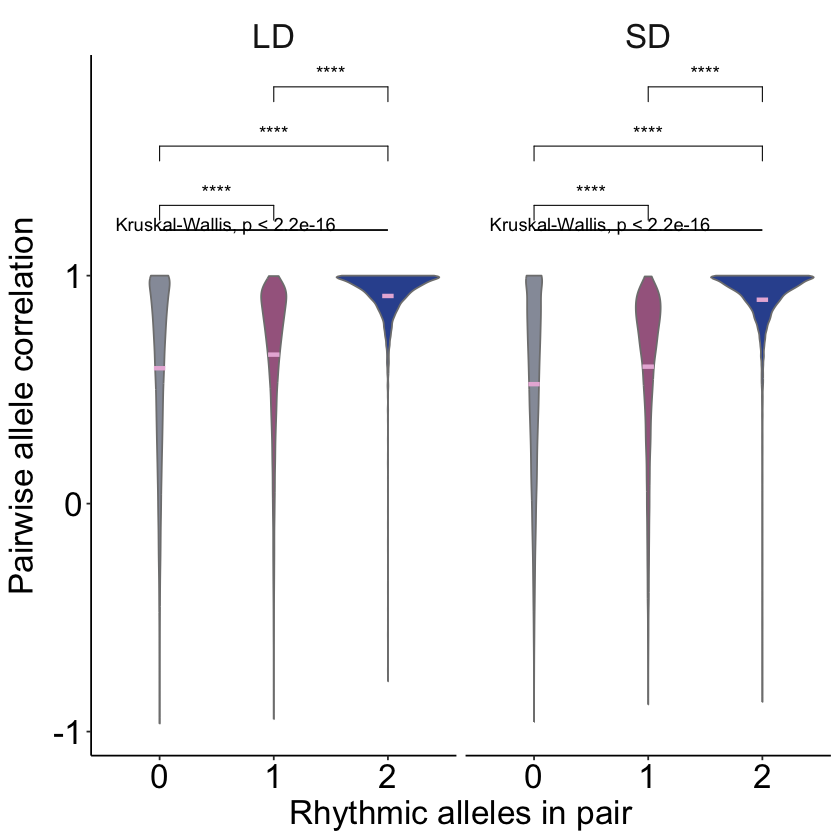

In [52]:
# Plot correlation according to cycling alleles in SDLD data ONLY for statistical analyses
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::;

CycCorrPlot_SDLD_stat <-Corr %>% mutate(Cycling = case_when(ADJ.P_H1<0.001 & ADJ.P_H2>=0.001 |
                                    ADJ.P_H1>=0.001 & ADJ.P_H2 <0.001 ~ '1',
                                    ADJ.P_H1<0.001 & ADJ.P_H2 <0.001 ~ '2',
                                   ADJ.P_H1>=0.001 & ADJ.P_H2>=0.001  ~ '0'))%>%
            select (Syntelog, Condition, Correlation,Cycling ) %>% 
            filter(!is.na(Cycling))%>%
            unique() %>%
            mutate(Cycling = as.factor(Cycling))%>%
            filter(!is.na(Condition), !is.na(Correlation))%>%
            filter(Condition == 'LD' | Condition == 'SD') %>% 
            
            ggplot(aes(x= Cycling, y = Correlation))+
              geom_violin(trim=TRUE, aes(group = Cycling, col = 'black', fill = Cycling))+
               #geom_boxplot(width=0.05,outlier.shape = NA)+
            labs(y="Pairwise allele correlation", x="Rhythmic alleles in pair")+

            stat_summary(fun = mean,
               geom = "crossbar", 
               width = 0.1,
               colour = "#E8B7DA")+   


 scale_color_manual(values = c('2' = '#33539E',  ##1F449C #darker blue/grey
                                    '1'= '#A5678E',   ##7CA1CC
                                      '0' = '#969ba8'))+ # blue
    scale_fill_manual(values = alpha(c('2' = '#33539E', #darker blue/grey  '#1F449C'
                                    '1'= '#A5678E',   #7CA1CC
                                      '0' = '#969ba8')))+

              #coord_cartesian(ylim=c(-1,1.2)) + # this will change the axis of the plot but will not remove data for statistical analyses
                            
            #geom_dotplot(binaxis='y', stackdir='center', dotsize=1)+
            theme_classic()+
            theme (
            axis.title.x = element_text(size = 20),
            axis.title.y = element_text(size = 20),
            axis.text = element_text(size = 20, color = "black"),
                 strip.text.x = element_text(size = 20),
            legend.position="none",
            strip.background = element_rect(color = "white"),
          strip.placement = "inside",
          strip.text = element_text(vjust = 0)) +
 annotate("segment",x = 1,xend = 3,y = 1.2,yend =1.2, size = 0.5,)+
        facet_grid(cols = vars(Condition))+

stat_compare_means(method= 'kruskal.test') + #Kruskal-Wallis multiple comparisons test
        
stat_compare_means(method = 'wilcox.test', ## for posthoc pairwise test
                           comparisons = list(c('0','1'), c('0', '2'), c('1','2')),  p.adjust.method = "BH" ,
                           size = 4,
                           label = "p.signif"
                          )
  
CycCorrPlot_SDLD_stat 
#http://www.sthda.com/english/articles/24-ggpubr-publication-ready-plots/76-add-p-values-and-significance-levels-to-ggplots/

In [53]:
## Summarize statistical results
#:::::::::::::::::::::::::::::::::::
label_SDLD <- data.frame( same = c('a', 'b', 'c','a','b','c'), 
                     Cycling = c('0','1','2','0','1','2'),
                     Condition = c('SD', 'SD','SD','LD','LD','LD'))

label_SDLD
label_SDLD$Condition<- as.factor(label_SDLD$Condition)


same,Cycling,Condition
<chr>,<chr>,<chr>
a,0,SD
b,1,SD
c,2,SD
a,0,LD
b,1,LD
c,2,LD


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


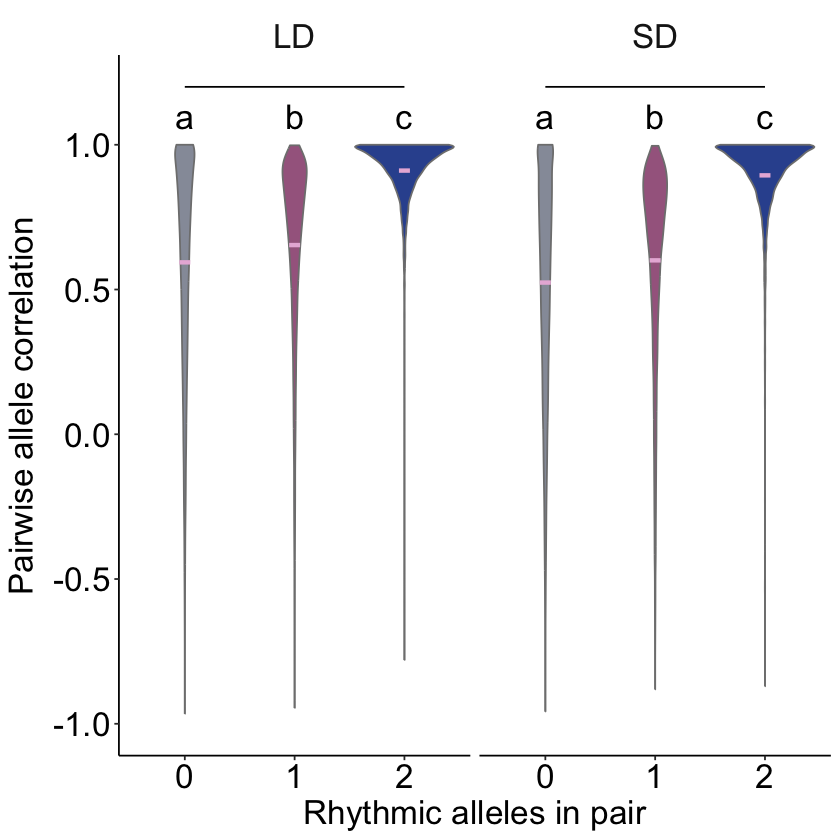

In [54]:
# Plot correlation according to cycling alleles in SDLD data ONLY for figure
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::;

CycCorrPlot_SDLD<-Corr %>% mutate(Cycling = case_when(ADJ.P_H1<0.001 & ADJ.P_H2>=0.001 |
                                    ADJ.P_H1>=0.001 & ADJ.P_H2 <0.001 ~ '1',
                                    ADJ.P_H1<0.001 & ADJ.P_H2 <0.001 ~ '2',
                                   ADJ.P_H1>=0.001 & ADJ.P_H2>=0.001  ~ '0'))%>%
            select (Syntelog, Condition, Correlation,Cycling ) %>% 
            filter(!is.na(Cycling))%>%
            unique() %>%
            mutate(Cycling = as.factor(Cycling))%>%
            filter(!is.na(Condition), !is.na(Correlation))%>%
            filter(Condition == 'LD' | Condition == 'SD') %>% 
            
            ggplot(aes(x= Cycling, y = Correlation))+
              geom_violin(trim=TRUE, aes(group = Cycling, col = 'black', fill = Cycling))+
               #geom_boxplot(width=0.05,outlier.shape = NA)+
            labs(y="Pairwise allele correlation", x="Rhythmic alleles in pair")+

            stat_summary(fun = mean,
               geom = "crossbar", 
               width = 0.1,
               colour = "#E8B7DA")+   


 scale_color_manual(values = c('2' = '#33539E',  ##1F449C #darker blue/grey
                                    '1'= '#A5678E',   ##7CA1CC
                                      '0' = '#969ba8'))+ # blue
    scale_fill_manual(values = alpha(c('2' = '#33539E', #darker blue/grey  '#1F449C'
                                    '1'= '#A5678E',   #7CA1CC
                                      '0' = '#969ba8')))+

           #scale_color_manual(values = c(
            #                    '0'= '#7CA1CC', 
             #                    '1'='#3D65A5', 
              #                   '2'='#1F449C'))+ 
            #scale_fill_manual(values = c(
             #                   '0'= '#7CA1CC', 
              #                   '1'='#3D65A5', 
               #                  '2'='#1F449C'))+ 
              coord_cartesian(ylim=c(-1,1.2)) + # this will change the axis of the plot but will not remove data for statistical analyses
                            
            #geom_dotplot(binaxis='y', stackdir='center', dotsize=1)+
            theme_classic()+
            theme (
            axis.title.x = element_text(size = 20),
            axis.title.y = element_text(size = 20),
            axis.text = element_text(size = 20, color = "black"),
                 strip.text.x = element_text(size = 20),
            legend.position="none",
            strip.background = element_rect(color = "white"),
          strip.placement = "inside",
          strip.text = element_text(vjust = 0)) +
 annotate("segment",x = 1,xend = 3,y = 1.2,yend = 1.2, size = 0.5,)+
        facet_grid(cols = vars(Condition))+

geom_text( data = label_SDLD, aes(label = same, x=Cycling, y = 1.1), nudge_x=0, nudge_y=0,check_overlap=T, size = 7.2) # Need to multiply by 0.36 to adjust to the other text sizes
  
CycCorrPlot_SDLD 
#http://www.sthda.com/english/articles/24-ggpubr-publication-ready-plots/76-add-p-values-and-significance-levels-to-ggplots/

In [55]:
CycCorrPlot_SDLD  %>% ggsave(file="./Results/CycCorrPlot_SDLD.pdf", 
                            width=5, height=5, dpi=600)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


## Tissue and Stress datasets

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


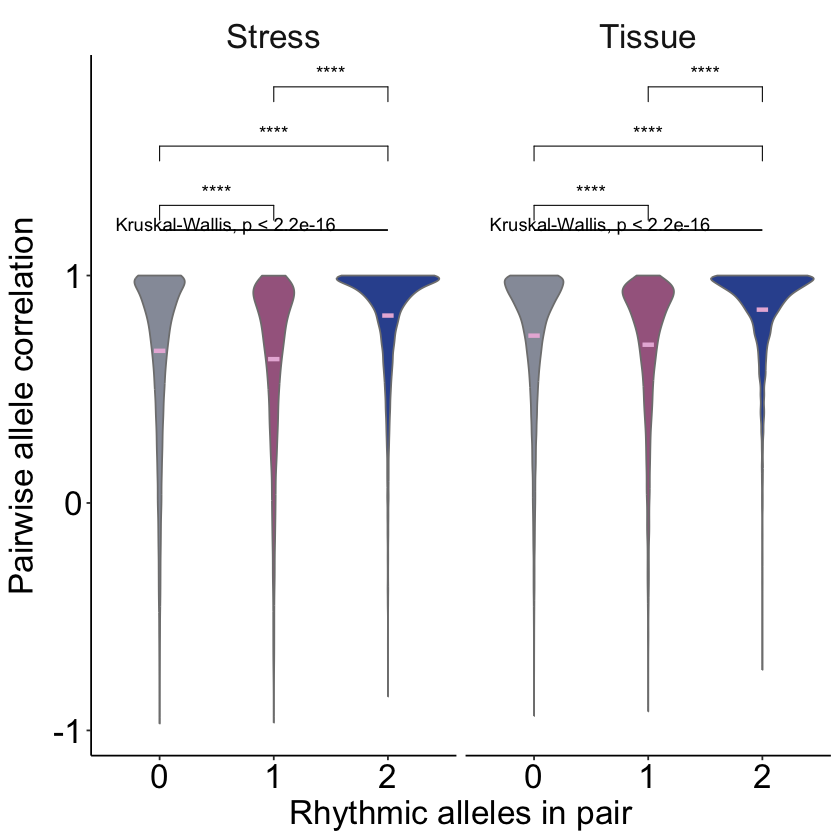

In [56]:
# Plot correlation according to cycling alleles in TISSUE and STRESS data ONLY for statistical analyses
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::;

CycCorrPlot_TS_stat <-Corr %>% mutate(Cycling = case_when(ADJ.P_H1<0.001 & ADJ.P_H2>=0.001 |
                                    ADJ.P_H1>=0.001 & ADJ.P_H2 <0.001 ~ '1',
                                    ADJ.P_H1<0.001 & ADJ.P_H2 <0.001 ~ '2',
                                   ADJ.P_H1>=0.001 & ADJ.P_H2>=0.001  ~ '0'))%>%
            select (Syntelog, Condition, Correlation,Cycling ) %>% 
            filter(!is.na(Cycling))%>%
            unique() %>%
            mutate(Cycling = as.factor(Cycling))%>%
            filter(!is.na(Condition), !is.na(Correlation))%>%
            filter(Condition == 'Tissue' | Condition == 'Stress') %>% 
            
            ggplot(aes(x= Cycling, y = Correlation))+
              geom_violin(trim=TRUE, aes(group = Cycling, col = 'black', fill = Cycling))+
               #geom_boxplot(width=0.05,outlier.shape = NA)+
            labs(y="Pairwise allele correlation", x="Rhythmic alleles in pair")+

            stat_summary(fun = mean,
               geom = "crossbar", 
               width = 0.1,
               colour = "#E8B7DA")+   


 scale_color_manual(values = c('2' = '#33539E',  ##1F449C #darker blue/grey
                                    '1'= '#A5678E',   ##7CA1CC
                                      '0' = '#969ba8'))+ # blue
    scale_fill_manual(values = alpha(c('2' = '#33539E', #darker blue/grey  '#1F449C'
                                    '1'= '#A5678E',   #7CA1CC
                                      '0' = '#969ba8')))+

              #coord_cartesian(ylim=c(-1,1.2)) + # this will change the axis of the plot but will not remove data for statistical analyses
                            
            #geom_dotplot(binaxis='y', stackdir='center', dotsize=1)+
            theme_classic()+
            theme (
            axis.title.x = element_text(size = 20),
            axis.title.y = element_text(size = 20),
            axis.text = element_text(size = 20, color = "black"),
                 strip.text.x = element_text(size = 20),
            legend.position="none",
            strip.background = element_rect(color = "white"),
          strip.placement = "inside",
          strip.text = element_text(vjust = 0)) +
 annotate("segment",x = 1,xend = 3,y = 1.2,yend =1.2, size = 0.5,)+
        facet_grid(cols = vars(Condition))+

stat_compare_means(method= 'kruskal.test') + #Kruskal-Wallis multiple comparisons test
        
stat_compare_means(method = 'wilcox.test', ## for posthoc pairwise test
                           comparisons = list(c('0','1'), c('0', '2'), c('1','2')),  p.adjust.method = "BH" ,
                           size = 4,
                           label = "p.signif"
                          )
  
CycCorrPlot_TS_stat 
#http://www.sthda.com/english/articles/24-ggpubr-publication-ready-plots/76-add-p-values-and-significance-levels-to-ggplots/

In [57]:
## Summarize statistical results
#:::::::::::::::::::::::::::::::::::
label_TS <- data.frame( same = c('a', 'b', 'c','a','b','c'), 
                     Cycling = c('0','1','2','0','1','2'),
                     Condition = c('Tissue', 'Tissue','Tissue','Stress','Stress','Stress'))

label_TS
label_TS$Condition<- as.factor(label_TS$Condition)

same,Cycling,Condition
<chr>,<chr>,<chr>
a,0,Tissue
b,1,Tissue
c,2,Tissue
a,0,Stress
b,1,Stress
c,2,Stress


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


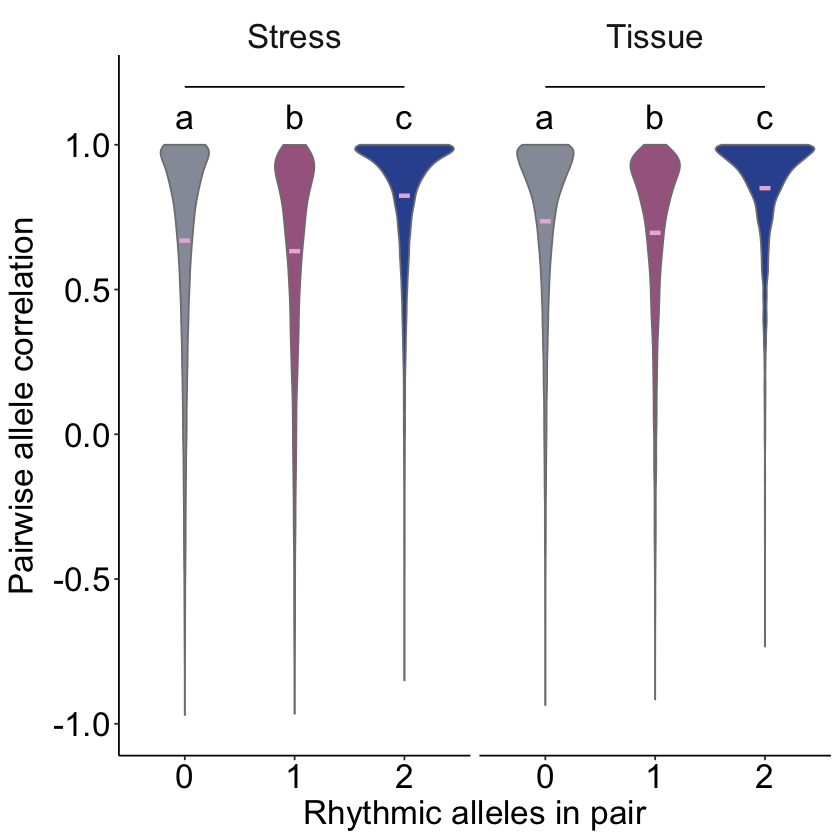

In [58]:
# Plot correlation according to cycling alleles in Tissue & Stress data ONLY
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::;

CycCorrPlot_TS<-Corr %>% mutate(Cycling = case_when(ADJ.P_H1<0.001 & ADJ.P_H2>=0.001 |
                                    ADJ.P_H1>=0.001 & ADJ.P_H2 <0.001 ~ '1',
                                    ADJ.P_H1<0.001 & ADJ.P_H2 <0.001 ~ '2',
                                   ADJ.P_H1>=0.001 & ADJ.P_H2>=0.001  ~ '0'))%>%
            select (Syntelog, Condition, Correlation,Cycling ) %>% 
            filter(!is.na(Cycling))%>%
            unique() %>%
            mutate(Cycling = as.factor(Cycling))%>%
            filter(!is.na(Condition), !is.na(Correlation))%>%
            filter(Condition == 'Tissue' | Condition == 'Stress') %>% 
            
            ggplot(aes(x= Cycling, y = Correlation))+
              geom_violin(trim=TRUE, aes(group = Cycling, col = 'black', fill = Cycling))+
               #geom_boxplot(width=0.05,outlier.shape = NA)+
            labs(y="Pairwise allele correlation", x="Rhythmic alleles in pair")+

            stat_summary(fun = mean,
               geom = "crossbar", 
               width = 0.1,
              colour = "#E8B7DA")+   


 scale_color_manual(values = c('2' = '#33539E',  ##1F449C #darker blue/grey
                                    '1'= '#A5678E',   ##7CA1CC
                                      '0' = '#969ba8'))+ # blue
    scale_fill_manual(values = alpha(c('2' = '#33539E', #darker blue/grey  '#1F449C'
                                    '1'= '#A5678E',   #7CA1CC
                                      '0' = '#969ba8')))+
              coord_cartesian(ylim=c(-1,1.2)) + # this will change the axis of the plot but will not remove data for statistical analyses
                            
            #geom_dotplot(binaxis='y', stackdir='center', dotsize=1)+
            theme_classic()+
            theme (
            axis.title.x = element_text(size = 20),
            axis.title.y = element_text(size = 20),
            axis.text = element_text(size = 20, color = "black"),
                 strip.text.x = element_text(size = 20),
            legend.position="none",
            strip.background = element_rect(color = "white"),
          strip.placement = "inside",
          strip.text = element_text(vjust = 0)) +
 annotate("segment",x = 1,xend = 3,y = 1.2,yend = 1.2, size = 0.5,)+
        facet_grid(cols = vars(Condition))+

geom_text( data = label_TS, aes(label = same, x=Cycling, y = 1.1), nudge_x=0, nudge_y=0,check_overlap=T, size = 7.2) # Need to multiply by 0.36 to adjust to the other text sizes
  
CycCorrPlot_TS
#http://www.sthda.com/english/articles/24-ggpubr-publication-ready-plots/76-add-p-values-and-significance-levels-to-ggplots/

In [59]:
CycCorrPlot_TS %>% ggsave(file="./Results/CycCorrPlot_TS.pdf", 
                            width=5, height=5, dpi=600)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
